## Imports

In [1]:
import tqdm as tqdm
from beta_vae.vae import VAE, VAEFlow, Decoder_AE_MNIST, Encoder_VAE_MNIST
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

import schedulefree

from torch.autograd import grad
from torch.autograd.forward_ad import dual_level, make_dual, unpack_dual

from torch.func import jacfwd, jacrev
from torch.func import functional_call, vmap

## Initalize

In [2]:
H_prior = 1/2*(1 + np.log(2*np.pi))

In [3]:
def reshape_condition(cond, kwargs_data):
    conditional = kwargs_data['conditional']
    conv_mode = kwargs_data['conv_mode']
    resolution = kwargs_data['resolution']
    
    if not conditional:
        cond = torch.zeros_like(cond)
    cond = nn.functional.one_hot(cond.to(torch.int64), num_classes=10).to(torch.float32).detach()
    
    if conv_mode==-1:
        return cond
    elif conv_mode==0:
        return [cond]
    elif conv_mode==1:
        cond1 = cond.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, resolution//2, resolution//2)
        cond2 = cond.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, resolution//4, resolution//4)
        return [cond, cond1, cond2]
    elif conv_mode==2:
        cond1 = cond.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, resolution//2, resolution//2)
        return [cond, cond1]
    elif conv_mode==3:
        cond1 = cond.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, resolution//2, resolution//2)
        cond2 = cond.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, resolution//4, resolution//4)
        cond3 = cond.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, resolution//8, resolution//8)
        return [cond, cond1, cond2, cond3]

In [4]:
def get_decoder_jacobian(model, conditional, kwargs_data, N_samples = 1000, N_repeats = 1, start_idx=0, only_cpu=False, mode_backward=True, new_method=False, random_sample=False, add_noise=True, use_train=True, equal_class=True, active_dim=None, print_info=False, z_array=None, c_array=None):
    resolution = kwargs_data['resolution']
    data_mean =  kwargs_data['data_mean']
    data_std = kwargs_data['data_std']
    noise_sigma = kwargs_data['noise_sigma']
    conv_mode = kwargs_data['conv_mode']
    use_styleGAN = kwargs_data['use_styleGAN']
    use_MNIST = kwargs_data['use_MNIST']
    use_GIN = kwargs_data['use_GIN']
    z_dim = kwargs_data['z_dim']
    x_dim = kwargs_data['x_dim']
    device = kwargs_data['device']

    if use_GIN:
        mu = kwargs_data['mu'].clone()
        sig = kwargs_data['sig'].clone()
    
    # if N_samples is too large for the GPU memory, we can split the computation into N_repeats chunks
    # if N_repeats > 1, then we will recursively call this function N_repeats times and append the results
    if N_repeats > 1:
        full_jac_array, ljd, c, z = get_decoder_jacobian(model, conditional, kwargs_data, N_samples, N_repeats=1, start_idx=0, mode_backward=mode_backward, random_sample=random_sample, use_train=use_train, active_dim=active_dim, print_info=print_info)
        if active_dim is not None:
            z_dim_temp = len(active_dim)
            assert mode_backward == False
        else:
            z_dim_temp = z_dim

        full_jac_array_cond = full_jac_array.reshape(10, full_jac_array.shape[0]//10, z_dim_temp, x_dim)
        ljd_cond = ljd.reshape(10, ljd.shape[0]//10)
        c_cond = c.reshape(10, c.shape[0]//10)
        z_cond = z.reshape(10, z.shape[0]//10, z_dim_temp)

        if only_cpu:
            full_jac_array_cond = full_jac_array_cond.detach().clone().cpu()
            ljd_cond = ljd_cond.detach().clone().cpu()
            c_cond = c_cond.detach().clone().cpu()
            z_cond = z_cond.detach().clone().cpu()
        for idx_repeat in range(N_repeats-1):
            full_jac_array, ljd, c, z = get_decoder_jacobian(model, conditional, kwargs_data, N_samples, N_repeats=1, start_idx=(idx_repeat+1)*N_samples, mode_backward=mode_backward, random_sample=random_sample, use_train=use_train, active_dim=active_dim, print_info=print_info)
            if only_cpu:
                full_jac_array = full_jac_array.detach().clone().cpu()
                ljd = ljd.detach().clone().cpu()
                c = c.detach().clone().cpu()
                z = z.detach().clone().cpu()
            full_jac_array_cond = torch.cat((full_jac_array_cond, full_jac_array.reshape(10, full_jac_array.shape[0]//10, z_dim_temp, x_dim)), dim=1)
            ljd_cond = torch.cat((ljd_cond, ljd.reshape(10, ljd.shape[0]//10)), dim=1)
            c_cond = torch.cat((c_cond, c.reshape(10, c.shape[0]//10)), dim=1)
            z_cond = torch.cat((z_cond, z.reshape(10, z.shape[0]//10, z_dim_temp)), dim=1)

            del full_jac_array, ljd, c, z
            gc.collect()
            torch.cuda.empty_cache()

        full_jac_array_cond = full_jac_array_cond.reshape(-1, z_dim_temp, x_dim)
        ljd_cond = ljd_cond.reshape(-1)
        c_cond = c_cond.reshape(-1)
        z_cond = z_cond.reshape(-1, z_dim_temp)
        return full_jac_array_cond, ljd_cond, c_cond, z_cond

    if print_info: #use tqdm
        print_update_function = lambda x: tqdm.tqdm(x)
    else:
        print_update_function = lambda x: x
    
    if active_dim is not None:
        z_dim_temp = len(active_dim)
        assert mode_backward == False
    else:
        z_dim_temp = z_dim
    #compute full Jacobian with backward autodiff
    full_jac_array = torch.zeros((N_samples, z_dim_temp, x_dim)).to(device)
    if conditional or use_GIN:
        assert N_samples % 10 == 0

    if print_info:
        print('Use random samples from latent space')
    if use_GIN:
        z = mu[None,:,:] + torch.randn(N_samples//10, 1, z_dim).to(device)*sig[None,:,:]
        z = z.reshape(N_samples, z_dim)
    else:
        z = torch.randn(N_samples, z_dim).to(device)
    z.requires_grad = True
    #c = torch.randint(0, 10, (N,)).to(device)
    #equal amounts of each digits
    c = torch.arange(0, 10).repeat(N_samples//10).to(device)
    if c.shape[0] < N_samples:
        c = torch.cat([c, torch.randint(0, 10, (N_samples-c.shape[0],)).to(device)], 0)
    if not conditional or use_GIN:
        c = torch.zeros_like(c)
    cond = reshape_condition(c, kwargs_data)
    
    if z_array is not None:
        z = z_array
        c = c_array

    _, ljd = model(z, c=cond, rev = True)

    if mode_backward:
        if print_info:
            print('Computing Jacobian with backward autodiff')

        x, ljd = model(z, c=cond, rev = True)
        #print(x.shape)
        for i in print_update_function(range(x_dim)): #loop through all dims of x
            x_grad = grad((x*data_std).reshape(N_samples, -1)[:,i].sum(), z, create_graph=True)[0]# 
            full_jac_array[:,:,i] = x_grad.detach().to(device=device)

    else:
        if print_info:
            print('Computing Jacobian with forward autodiff')
        for i in print_update_function(range(z_dim_temp)): #loop through all dims of z
            z_grad = torch.zeros_like(z)
            if active_dim is not None:
                z_grad[:,active_dim[i]] = 1
            else:
                z_grad[:,i] = 1
            with dual_level():
                dual_z = make_dual(z, z_grad)
                dual_x, _ = model(dual_z, cond, rev=True)
                x_rec, x_grad = unpack_dual(dual_x)
            x_rec = x_rec * data_std + data_mean
            x_grad = x_grad * data_std
            #print(x_grad.shape)
            x_grad = x_grad.reshape(x_grad.shape[0], -1)
            full_jac_array[:,i] = x_grad.detach().to(device=device)

    if use_GIN:
        #sig_temp = sig[None,...].repeat(N_samples, 1, 1)[...,None]
        if random_sample:
            mask = torch.arange(0, 10).repeat(N_samples//10).to(device)
            full_jac_array = full_jac_array * sig[mask].unsqueeze(-1)
        else:
            full_jac_array = full_jac_array * sig[c].unsqueeze(-1)
    full_jac_array = full_jac_array.reshape(N_samples, z_dim_temp, x_dim) #expected to be ordered with as 0,1,2,..8,9,0,1...
    if active_dim is not None:
        z = z[:, active_dim]
    return full_jac_array.detach(), ljd.detach().to(device=device), c.detach().to(device=device), z.detach().to(device=device)

In [5]:
def evaluate_flow(flow, conditional, kwargs_data, N_samples=2000, N_repeats=2, print_info=False, mode_backward=True, new_method=False, add_noise=True, use_train=True, equal_class=True, get_z=False, active_dim=None, random_sample=False, device='cpu'):
    z_dim = kwargs_data['z_dim']
    x_dim = kwargs_data['x_dim']
    #jacobian
    jac, ljd, c, z = get_decoder_jacobian(flow, conditional=conditional, kwargs_data=kwargs_data, N_samples = N_samples, N_repeats = N_repeats, only_cpu=True, mode_backward=mode_backward, random_sample=random_sample, add_noise=add_noise, use_train=use_train, equal_class=equal_class, active_dim=active_dim, print_info=print_info)
    if active_dim is not None:
        z_dim_temp = len(active_dim)
    else:
        z_dim_temp = z_dim
    jac_cond = jac.reshape(10, jac.shape[0]//10, z_dim_temp, x_dim)
    
    H_cond = H_prior + ljd.reshape(10, ljd.shape[0]//10)/z_dim_temp
    z = z.reshape(10, z.shape[0]//10, z_dim_temp)#.to(device)
    H_i_cond = H_prior + torch.zeros((10, z_dim_temp), dtype=torch.float64)#.to(device)

    update_func = lambda x: x
    if print_info:
        update_func = lambda x: tqdm.tqdm(x)

    for i in update_func(range(z_dim_temp)):
        H_i_cond[:,i]      = torch.mean(1/2*torch.log(torch.sum(jac_cond[:,:,i,:]**2, -1)), -1)

    z2 = 1/2*torch.mean(z**2, (0,1))
    H_i = H_i_cond.mean(0) #+ z2
    latent_sort = torch.argsort(H_i, descending=True)
    
    del jac, ljd, c
    del H_i
    gc.collect()
    torch.cuda.empty_cache()
    if not get_z:
        return jac_cond, H_cond, H_i_cond, latent_sort
    else:
        return jac_cond, H_cond, H_i_cond, latent_sort, z

In [6]:
def get_MPMI_conditional(jac1, jac2, kwargs_data, max_dim=None, dtype=torch.float64, average_over_condition=False, device='cpu', print_info=True):
    z_dim = kwargs_data['z_dim']
    conditional = kwargs_data['conditional']
    if max_dim == None:
        max_dim = z_dim
    assert jac1.shape == jac2.shape

    # The computation can sometimes be faster on the cpu
    jac1 = jac1.to(device=device).to(dtype=dtype)
    jac2 = jac2.to(device=device).to(dtype=dtype)

    if (jac1 == jac2).all():
        comp_cross = False
    else:
        comp_cross = True

    MPMI_ij_cond = torch.zeros((10, max_dim, max_dim), dtype=dtype).to(device=device)

    #jac1 = jac1.reshape(N//10, 10, z_dim, z_dim).transpose(0, 1)[:,:,sort1][:,:,:,sort1]
    #jac2 = jac2.reshape(N//10, 10, z_dim, z_dim).transpose(0, 1)[:,:,sort2][:,:,:,sort2]

    if jac1.dim() == 3:
        jac1 = jac1.unsqueeze(0)
    if jac2.dim() == 3:
        jac2 = jac2.unsqueeze(0)
    
    assert jac1.dim() == 4

    N = jac1.shape[1]
    if conditional:
        assert N % 10 == 0

    #precompute jac_det_i
    jac_det_1i = torch.log(torch.sum(jac1[:,:,:,:]**2, -1))
    jac_det_2i = torch.log(torch.sum(jac2[:,:,:,:]**2, -1))

    update_func = lambda x: x
    if print_info:
        update_func = lambda x: tqdm.tqdm(x)
        print(f'Computing {'MCPMI' if comp_cross else 'MPMI'} matrix')

    for i in update_func(range(max_dim)):
        second_range = range(max_dim) if comp_cross else range(i+1, max_dim)
        idx = torch.tensor([i,0])
        #submatrix = torch.cat((jac1[:,:,idx[0],:].unsqueeze(2), jac2[:,:,idx[1],:].unsqueeze(2)), 2)
        for j in second_range:
            #print(i, j)
            idx = torch.tensor([i,j])#.to(device='cuda')
            #submatrix = full_jac_array_cond[:,:,idx,:].to(device='cuda')
            #submatrix[:,:,1,:] = jac1[:,:,idx[1],:]
            submatrix = torch.cat((jac1[:,:,idx[0],:].unsqueeze(2), jac2[:,:,idx[1],:].unsqueeze(2)), 2)
            #print(submatrix.shape)
            #return
            #print(idx)
            GTG = torch.einsum('xyij, xykj -> xyik', submatrix, submatrix)
            #print(GTG.shape)
            #jac_det_12 = torch.logdet(GTG)
            jac_det_12 = GTG[...,0,0]*GTG[...,1,1] - GTG[...,0,1]*GTG[...,1,0]
            jac_det_12 = torch.log(jac_det_12)
            #print(jac_det_12.shape)
            

            #print(jac_det_12)
            #jac_det_1 = torch.log(torch.sum(submatrix[:,:,0,:]**2, -1))
            #jac_det_2 = torch.log(torch.sum(submatrix[:,:,1,:]**2, -1))
            jac_det_1 = jac_det_1i[:,:,idx[0]]
            jac_det_2 = jac_det_2i[:,:,idx[1]]
            if jac_det_1.isnan().any() or jac_det_2.isnan().any() or jac_det_12.isnan().any():
                print('Is nan!')
                print(jac_det_1)
                print(jac_det_2)
                print(jac_det_12)
                return
            #inf_mask = jac_det_12.isinf()
            #if i == j: print(jac_det_12)
            #if i == j:
            #    jac_det_12 = 0 #torch.max(jac_det_1, jac_det_2)
            #jac_det_12[inf_mask] = torch.max(jac_det_1[inf_mask], jac_det_2[inf_mask])

            MPMI_ij_cond[:,i,j] = 1/2*torch.mean(jac_det_12 - jac_det_1 - jac_det_2, -1).to(device=device).to(dtype=dtype)
    if average_over_condition:
        MPMI_ij_cond = -MPMI_ij_cond.mean(0)
    return MPMI_ij_cond.to(device=device).to(dtype=dtype)

In [7]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [8]:
current_folder = 'beta_vae'

content_path = os.path.join(current_folder, 'notebooks')
data_path = os.path.join(current_folder, 'data')

if not os.path.exists(content_path + '/VAE/'):
    os.makedirs(content_path + '/VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

torch.manual_seed(0)

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


In [9]:
def loss_function_VAE(recon_x, x, mu, logvar, beta):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # Sigmoid
    #recon_loss = F.mse_loss(recon_x, x, reduction='sum') # Sigmoid
    kl_divergence = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
    loss = recon_loss + beta*kl_divergence
    return loss, recon_loss, kl_divergence

def step(model, optimizer, data, label, beta, training=True):
    data = data.to(device)
    label = label.to(device)
    #make one hot vector
    label = F.one_hot(label, num_classes=10).to(torch.float32)
    optimizer.zero_grad()
    recon_x, x, mu, logvar = model(data, c=label)
    loss, bce_loss, kld_loss = loss_function_VAE(recon_x, x, mu, logvar, beta)
    if training:
        loss.backward()
        optimizer.step()
    return loss, kld_loss, bce_loss

In [10]:
def train_bVAE(model, optimizer, loader_train, loader_test, num_epochs, beta, latent_dim, losses, conditional=False, show_progress=True):
    for epoch in range(num_epochs):
        total_loss_mean = 0
        kld_mean = 0
        bce_mean = 0
        model.train()
        optimizer.train()
        with tqdm.tqdm(loader_train, unit="batch") as tepoch:
            for batch_idx, (data, label) in enumerate(tepoch):
                loss, kld_loss, bce_loss = step(model, optimizer, data, label, beta)
                total_loss_mean += loss.detach().item()
                kld_mean += kld_loss.detach().item()
                bce_mean += bce_loss.detach().item()
                if show_progress and batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item()/len(data))

        losses["train_total_loss"].append(total_loss_mean/len(loader_train))
        losses["train_bce"].append(bce_mean/len(loader_train))
        losses["train_KLD"].append(kld_mean/len(loader_train))

        total_loss_mean = 0
        kld_mean = 0
        bce_mean = 0
        model.eval()

        for batch_idx, (data, label) in enumerate(loader_test):
            loss, kld_loss, bce_loss = step(model, optimizer, data, label, beta, training=False)
            total_loss_mean += loss.detach().item()
            kld_mean += kld_loss.detach().item()
            bce_mean += bce_loss.detach().item()

        losses["test_total_loss"].append(total_loss_mean/len(loader_test))
        losses["test_bce"].append(bce_mean/len(loader_test))
        losses["test_KLD"].append(kld_mean/len(loader_test))

    #save model and losses
    if conditional:
        model_name = f'cVAE_{latent_dim}_{beta}_{num_epochs}'
    else:
        model_name = f'VAE_{latent_dim}_{beta}_{num_epochs}'
    torch.save(model.state_dict(), content_path + f'/VAE/{model_name}.pt')
    np.save(content_path + f'/VAE/{model_name}.npy', losses)

In [11]:
# Load EMNIST 28x28
use_EMNIST = True

batch_size = 128

kwargs = {}
train_dat = datasets.EMNIST('./data', split='digits', train=True, download=True, transform=transforms.ToTensor()) #transforms.Pad(2),
loader_train = torch.utils.data.DataLoader(train_dat, batch_size=batch_size, shuffle=True, num_workers=10, **kwargs)
test_dat = datasets.EMNIST('./data', split='digits', train=False, download=True, transform=transforms.ToTensor())
loader_test = torch.utils.data.DataLoader(test_dat, batch_size=batch_size, shuffle=False, num_workers=10, **kwargs)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path + '/VAE/image_original.png')

## Train beta-VAE for testing

In [13]:
model = VAE(encoder_hyper_params=encoder_hyper_params,
            decoder_hyper_params=decoder_hyper_params,
            conditional=conditional, conds=conds)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


plotting_dict = {
"train_total_loss": [],
"train_KLD": [],
"train_bce": [],
"test_total_loss": [],
"test_KLD": [],
"test_bce": [],
}

In [ ]:
num_epochs = 50
learning_rate = 3e-4 #5E-4

latent_dim = 100
beta = 10
conditional = False
conds = 0

In [24]:
x_dim = (1, 28, 28)
encoder = Encoder_VAE_MNIST(x_dim, latent_dim, conds=conds, ch_mult=4, use_resblocks=False)
decoder = Decoder_AE_MNIST(x_dim, latent_dim, conds=conds, ch_mult=4, use_resblocks=False)
model = VAE(encoder=encoder, decoder=decoder, latent_dim=latent_dim, conditional=conditional, conds=conds)
model = model.to(device)
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=learning_rate)
optimizer.train()

losses = {
"train_total_loss": [],
"train_KLD": [],
"train_bce": [],
"test_total_loss": [],
"test_KLD": [],
"test_bce": [],
}

In [ ]:
train_bVAE(model, optimizer, loader_train, loader_test, num_epochs, beta, latent_dim, losses, conditional, show_progress=True)

## Train Runs over many betas

Train beta-VAEs over different betas and latent_dims

In [19]:
num_epochs = 50
learning_rate = 3e-4

#latent_dim = 100
#beta = 1
conditional = False # True
conds = 0           # 10

In [16]:
content_path = 'beta_vae/runs'
#makedir
if not os.path.exists(content_path + '/VAE/'):
    os.makedirs(content_path + '/VAE/')

In [22]:
# original hyperparameter sweep
betas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
latent_dims = [10, 100]

In [18]:
# additional hyperparameter sweep
betas = [15, 30, 40]
latent_dims = [100]

In [ ]:
# Train all runs
for latent_dim in latent_dims:
    for beta in betas:
        print(f'beta={beta}, latent_dim={latent_dim}')

        x_dim = (1, 28, 28)
        encoder = Encoder_VAE_MNIST(x_dim, latent_dim, conds=conds, ch_mult=4, use_resblocks=False)
        decoder = Decoder_AE_MNIST(x_dim, latent_dim, conds=conds, ch_mult=4, use_resblocks=False)
        model = VAE(encoder=encoder, decoder=decoder, latent_dim=latent_dim, conditional=conditional, conds=conds)
        model = model.to(device)
        optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=learning_rate)

        losses = {
        "train_total_loss": [],
        "train_KLD": [],
        "train_bce": [],
        "test_total_loss": [],
        "test_KLD": [],
        "test_bce": [],
        }

        train_bVAE(model, optimizer, loader_train, loader_test, num_epochs, beta, latent_dim, losses, show_progress=False)

        gc.collect()
        torch.cuda.empty_cache()

## Load Runs

In [12]:
runs_path = 'beta_vae/runs/VAE/'
list_files = os.listdir(runs_path)
list_files = [f for f in list_files if 'VAE' in f]
list_files = sorted(list_files)
list_files = [f.split('.')[:-1] for f in list_files]
list_files = ['.'.join(f) for f in list_files]
list_files = list_files[::2]
print('Available saved runs:', list_files)

Available saved runs: ['VAE_100_0.01_50', 'VAE_100_0.02_50', 'VAE_100_0.05_50', 'VAE_100_0.1_50', 'VAE_100_0.2_50', 'VAE_100_0.5_50', 'VAE_100_100_50', 'VAE_100_10_50', 'VAE_100_15_50', 'VAE_100_1_50', 'VAE_100_20_50', 'VAE_100_2_50', 'VAE_100_30_50', 'VAE_100_40_50', 'VAE_100_50_50', 'VAE_100_5_50', 'VAE_10_0.01_50', 'VAE_10_0.02_50', 'VAE_10_0.05_50', 'VAE_10_0.1_50', 'VAE_10_0.2_50', 'VAE_10_0.5_50', 'VAE_10_100_50', 'VAE_10_10_50', 'VAE_10_1_50', 'VAE_10_20_50', 'VAE_10_2_50', 'VAE_10_50_50', 'VAE_10_5_50']


Select latent_dim and betas for analysis

In [13]:
latent_dim = 10
betas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]

In [14]:
latent_dim = 100
betas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 15, 20, 30, 40, 50, 100]

In [15]:
num_epochs = 50
conditional = False
conds = 0

kwargs_data = {
    'resolution': 28,
    'data_mean': 0,
    'data_std': 1,
    'noise_sigma': 0.1,
    'conv_mode': 0,
    'use_styleGAN': False,
    'use_MNIST': False,
    'use_GIN': False,
    'z_dim': latent_dim,
    'x_dim': 784,
    'conditional': conditional,
    'device': device
}

### Load all models and save in run_data

In [16]:
run_data = []


for beta in betas:
    file_name = f'VAE_{latent_dim}_{beta}_{num_epochs}'
    print(file_name)
    #check if file exists
    if file_name not in list_files:
        continue
    kwargs_data['z_dim'] = latent_dim
    
    x_dim = (1, 28, 28)
    encoder = Encoder_VAE_MNIST(x_dim, latent_dim, conds=conds, ch_mult=4, use_resblocks=False)
    decoder = Decoder_AE_MNIST(x_dim, latent_dim, conds=conds, ch_mult=4, use_resblocks=False)
    model = VAE(encoder=encoder, decoder=decoder, latent_dim=latent_dim, conditional=conditional, conds=conds)
    model = model.to(device)

    model.load_state_dict(torch.load(runs_path + file_name + '.pt'))

    losses = np.load(runs_path + file_name + '.npy', allow_pickle=True).item()

    flow = VAEFlow(model)
    flow = flow.to(device)

    run_data.append({
        'flow': flow,
        'losses': losses,
        'beta': beta,
        'latent_dim': latent_dim,
        'conditional': conditional,
    })

VAE_100_0.01_50
VAE_100_0.02_50
VAE_100_0.05_50
VAE_100_0.1_50
VAE_100_0.2_50
VAE_100_0.5_50
VAE_100_1_50
VAE_100_2_50
VAE_100_5_50
VAE_100_10_50
VAE_100_15_50
VAE_100_20_50
VAE_100_30_50
VAE_100_40_50
VAE_100_50_50
VAE_100_100_50


### Compute Jacobian and Manifold Entropic Metrics for all runs

In [17]:
for run in run_data:
    flow = run['flow']
    latent_dim = run['latent_dim']
    beta = run['beta']
    conditional = run['conditional']

    kwargs_data['z_dim'] = latent_dim
    print(f'Compute metrics for run: latent_dim={latent_dim}, beta={beta}')

    #evaluate the flow
    jac_cond, _, H_i_cond, latent_sort, z = evaluate_flow(flow, conditional, kwargs_data, N_samples=1000, N_repeats=1, print_info=True, mode_backward=True, add_noise=True, use_train=True, equal_class=False, get_z=True, random_sample=True, device=device)

    #compute the Total Entropy H from scratch because VAE doesn't return a valid ljd alongside the decoder and thus can't be used to compute the H
    H = H_prior + 1/2*torch.logdet((jac_cond.to(torch.float64) @ jac_cond.to(torch.float64).transpose(-1, -2))).mean()/latent_dim
    MTC = H_i_cond.mean() - H.mean()

    run.update({
        'jac_cond': jac_cond,
        'H_i_cond': H_i_cond,
        'latent_sort': latent_sort,
        'z': z,
        'H': H,
        'MTC': MTC,
    })

Compute metrics for run: latent_dim=100, beta=0.01
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 2726.35it/s]


Compute metrics for run: latent_dim=100, beta=0.02
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 341.98it/s]


Compute metrics for run: latent_dim=100, beta=0.05
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 341.14it/s]


Compute metrics for run: latent_dim=100, beta=0.1
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.30it/s]


Compute metrics for run: latent_dim=100, beta=0.2
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.68it/s]


Compute metrics for run: latent_dim=100, beta=0.5
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.07it/s]


Compute metrics for run: latent_dim=100, beta=1
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 339.65it/s]


Compute metrics for run: latent_dim=100, beta=2
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 339.46it/s]


Compute metrics for run: latent_dim=100, beta=5
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 339.83it/s]


Compute metrics for run: latent_dim=100, beta=10
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 341.02it/s]


Compute metrics for run: latent_dim=100, beta=15
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.97it/s]


Compute metrics for run: latent_dim=100, beta=20
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 341.14it/s]


Compute metrics for run: latent_dim=100, beta=30
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.16it/s]


Compute metrics for run: latent_dim=100, beta=40
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.10it/s]


Compute metrics for run: latent_dim=100, beta=50
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.36it/s]


Compute metrics for run: latent_dim=100, beta=100
Use random samples from latent space
Computing Jacobian with backward autodiff


100%|██████████| 100/100 [00:00<00:00, 340.80it/s]


### Plot loss at the end of training

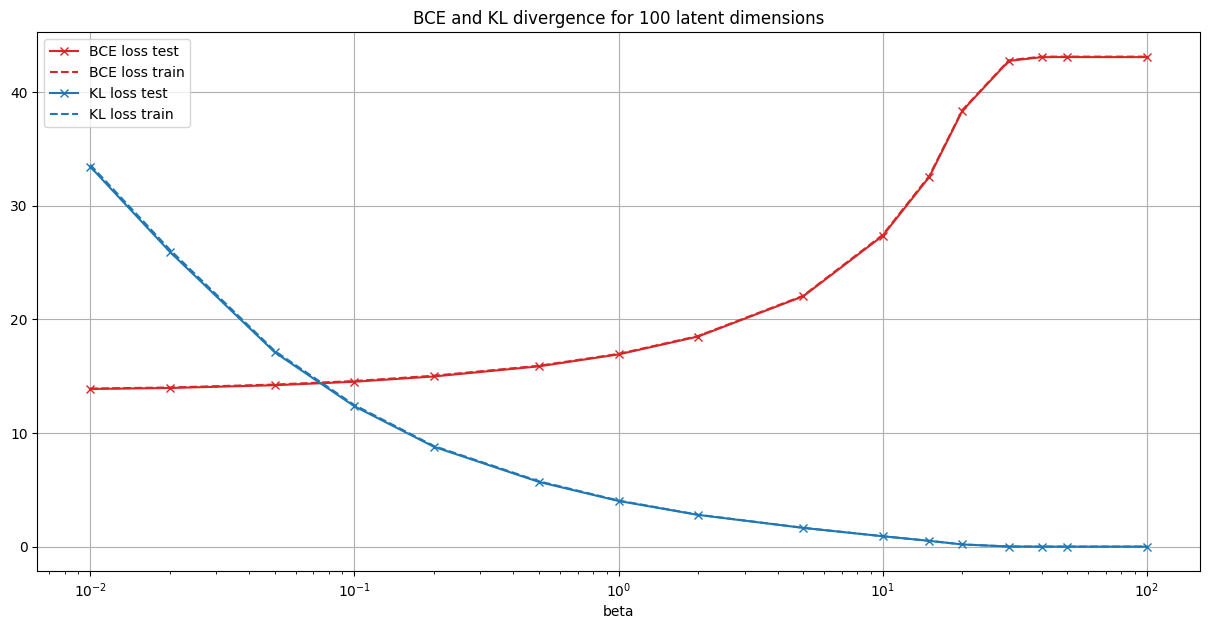

In [18]:
bce_test_losses = []
bce_train_losses = []

KL_test_losses = []
KL_train_losses = []

betas_temp = []
#for i, loss in enumerate(losses):
for i, run in enumerate(run_data):
    loss = run['losses']
    beta = run['beta']
    latent_dim = run['latent_dim']

    betas_temp.append(beta)

    test_temp = loss['test_bce']
    test_temp = np.mean(test_temp[-10:])
    bce_test_losses.append(test_temp/784)

    train_temp = loss['train_bce']
    train_temp = np.mean(train_temp[-10:])
    bce_train_losses.append(train_temp/784)

    test_temp = loss['test_KLD']
    test_temp = np.mean(test_temp[-10:])
    KL_test_losses.append(test_temp/784)

    train_temp = loss['train_KLD']
    train_temp = np.mean(train_temp[-10:])
    KL_train_losses.append(train_temp/784)


fig, ax1 = plt.subplots(figsize=(15, 7))
plt.title(f'BCE and KL divergence for {latent_dim} latent dimensions')

color = 'tab:red'
ax1.set_xlabel('beta')
#ax1.set_ylabel('bce', color=color)
ax1.plot(betas_temp, bce_test_losses, label='BCE loss test', color=color, marker='x')
ax1.plot(betas_temp, bce_train_losses, label='BCE loss train', color=color, linestyle='--')
#ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend()
ax1.grid()

ax2 = ax1#.twinx()
color = 'tab:blue'
#ax2.set_ylabel('KL', color=color)
ax2.plot(betas_temp, KL_test_losses, label='KL loss test', color=color, marker='x')
ax2.plot(betas_temp, KL_train_losses, label='KL loss train', color=color, linestyle='--')
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.legend()
#ax2.grid()

plt.show()
#save figure
#plt.savefig(runs_path + f'/losses_{latent_dim}.svg')

### Plot reconstructed and generated samples for one run

In [41]:
beta_plot = 10
assert beta_plot in betas

In [42]:
#find run with beta_plot = 1
run_idx = None
for i, run in enumerate(run_data):
    if run['beta'] == beta_plot:
        run_idx = i
        break
model_vae = run_data[run_idx]['flow'].vae.to(device)

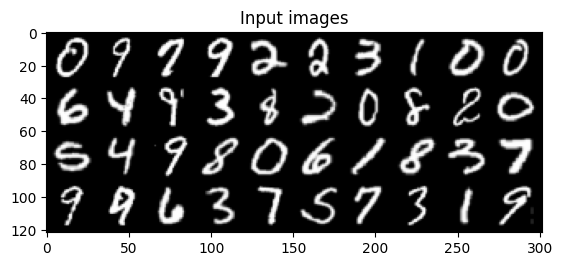

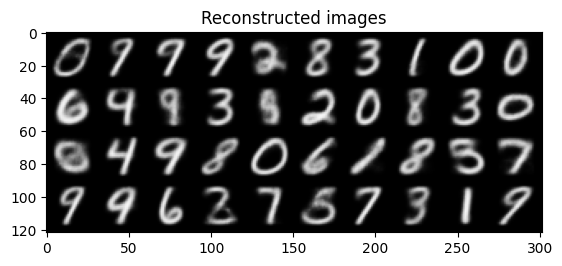

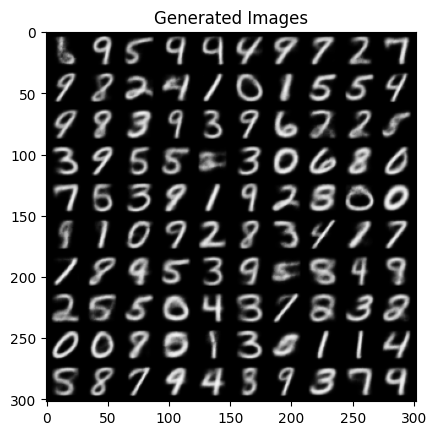

In [43]:
use_EMNIST = not kwargs_data['use_MNIST']

plt.figure()
plt.title('Input images')

sample_inputs, sample_lables = next(iter(loader_test))
fixed_input = sample_inputs[0:40, :, :, :]
sample_lables = sample_lables[0:40]

if use_EMNIST:
    fixed_input = fixed_input.permute(0, 1, 3, 2)
# visualize the original images of the last batch of the test set
img = make_grid(fixed_input, nrow=10, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
if use_EMNIST:
    fixed_input = fixed_input.permute(0, 1, 3, 2)
show(img)

plt.figure()
plt.title('Reconstructed images')
with torch.no_grad():
    fixed_input = fixed_input.to(device)
    sample_lables = F.one_hot(sample_lables, num_classes=10).to(torch.float32).to(device)
    recon_batch, _, _, _ = model_vae(fixed_input, c=sample_lables)
    if use_EMNIST:
        recon_batch = recon_batch.permute(0, 1, 3, 2)
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(recon_batch, nrow=10, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    show(recon_batch)

plt.figure()
plt.title('Generated Images')
model_vae.eval()
n_samples = 100
z = torch.randn(n_samples,latent_dim).to(device)
label = torch.arange(n_samples).to(device)%10
label = F.one_hot(label, num_classes=10).to(torch.float32)
with torch.no_grad():
    samples = model_vae.decode(z, c=label)
    if use_EMNIST:
        samples = samples.permute(0, 1, 3, 2)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=10, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    show(samples)
plt.show()

### Show Manifold Entropy Spectra for all runs

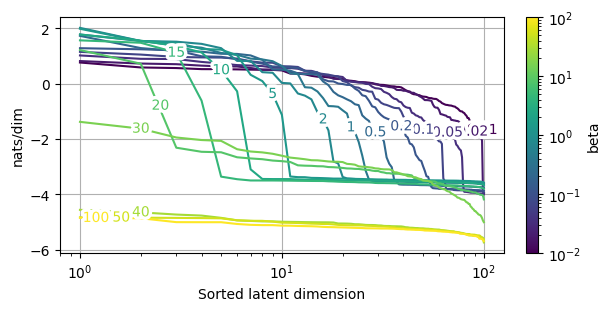

In [23]:
#plot Manifold Entropy Spectra for all betas
colors = plt.cm.viridis(np.linspace(0, 1, len(run_data)))

fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True) #(8, 4)
#plt.title(f'Manifold Entropy Spectrum for beta-VAEs with {latent_dim} latent dimensions', fontsize=12)

x_axis = np.arange(1, latent_dim+1)

xvals = []
#for i, H_i in enumerate(H_i_array):
for i, run in enumerate(run_data):
    beta = run['beta']
    if beta > 1000:
        continue
    latent_dim = run['latent_dim']
    H_i = run['H_i_cond'].mean(0).cpu().numpy() #take mean over all conditions
    #sort H_i
    #H_i_sorted = np.sort(H_i)[::-1]
    H_i_sorted = H_i[run['latent_sort']]
    ax.plot(x_axis, H_i_sorted, label=f'{beta}', color=colors[i])
    try:
        xvals.append(np.where(H_i_sorted>-1.8)[0][-1])
    except:
        xvals.append(1)
plt.grid()
plt.ylabel('nats/dim')
#plt.legend()
plt.xscale('log')

xvals = np.array(xvals, dtype=float)

if 100 in betas and xvals.shape[0] > 5:
    xvals[-5:] = np.array([1.5, 1, 1, 0.6, 0.2])+1

labelLines(ax.get_lines(), align=False, xvals=xvals)
plt.xlabel('Sorted latent dimension')

#add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.LogNorm())
sm.set_array(betas)
plt.colorbar(sm, label='beta', ax=plt.gca()) #ticks=betas, 

#plt.show()
plt.savefig(runs_path + f'/H_i_{latent_dim}_small.svg', transparent=True)

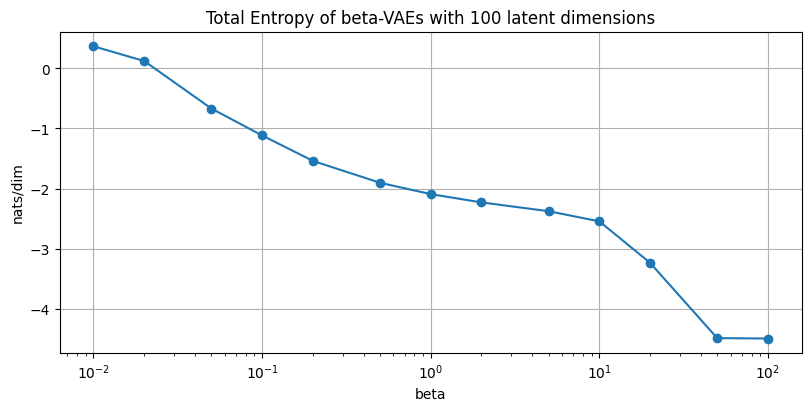

In [61]:
#plot Total Entropy
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
plt.title(f'Total Entropy of beta-VAEs with {latent_dim} latent dimensions')
H_array = []
for i, run in enumerate(run_data):
    beta = run['beta']
    latent_dim = run['latent_dim']
    H = run['H'].cpu().numpy() 
    H_array.append(H)

plt.plot(betas, H_array, 'o-')
plt.xscale('log')
plt.grid()

plt.xlabel('beta')
plt.ylabel('nats/dim')

plt.show()
#save figure
#plt.savefig(runs_path + f'/H_full_{latent_dim}.svg', transparent=True)

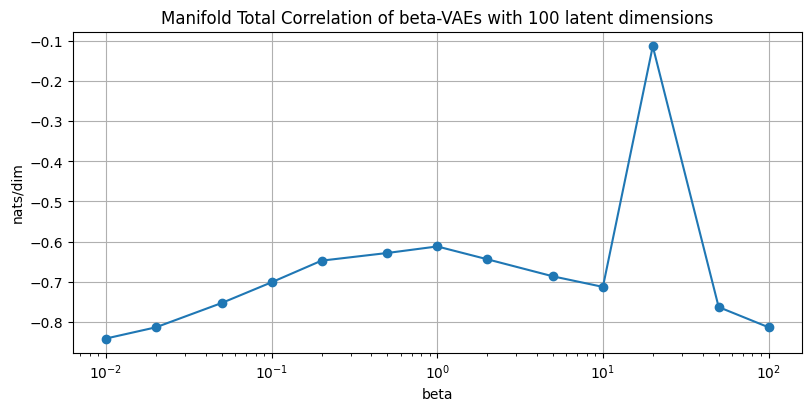

In [62]:
#plot MTC vs beta

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
plt.title(f'Manifold Total Correlation of beta-VAEs with {latent_dim} latent dimensions')

MTC_array = [run['MTC'].item() for run in run_data]
beta_array = [run['beta'] for run in run_data]

plt.plot(beta_array, MTC_array, 'o-')
plt.ylabel('nats/dim')
plt.xlabel('beta')
plt.xscale('log')
plt.grid()
plt.show()

#save figure
#plt.savefig(runs_path + f'/MTC_{latent_dim}.svg', transparent=True)

### Plot MPMI for one run

In [63]:
beta_plot = 1
assert beta_plot in betas

In [64]:
#find run with beta_plot = 1
run_idx = None
for i, run in enumerate(run_data):
    if run['beta'] == beta_plot:
        run_idx = i
        break
latent_sort = run_data[run_idx]['latent_sort']
jac_cond_sorted = run_data[run_idx]['jac_cond'][:, :, latent_sort, :]
MPMI = get_MPMI_conditional(jac_cond_sorted, jac_cond_sorted, kwargs_data, max_dim=kwargs_data['z_dim'], dtype=torch.float64, device='cpu', average_over_condition=True) 

Computing MPMI matrix


100%|██████████| 100/100 [00:02<00:00, 36.28it/s]


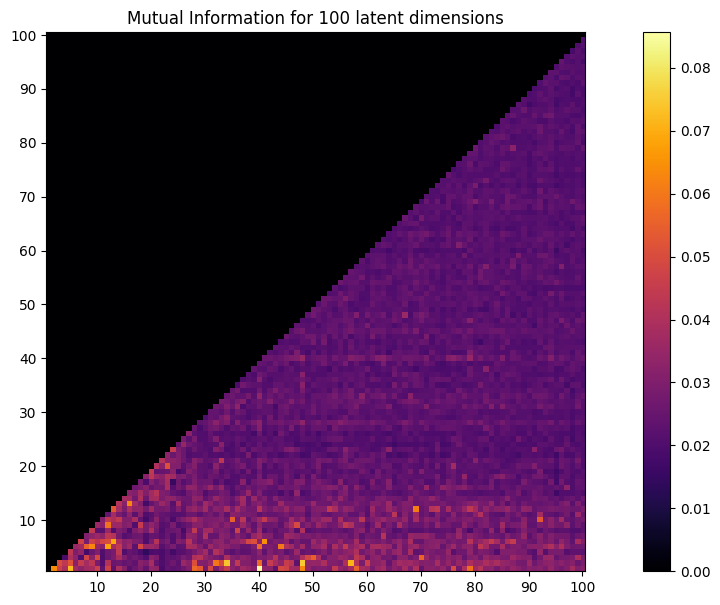

In [65]:
#plot MI
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plt.title(f'Mutual Information for {latent_dim} latent dimensions')

N_dim = 100
N_step = 10
plt.imshow(np.flip(MPMI.cpu().numpy()[0:N_dim, 0:N_dim], axis=0), cmap='inferno', interpolation='nearest', extent=[0, N_dim, 0, N_dim])#, vmax=0.05)
plt.xticks(np.arange(N_step-1, N_dim+1, N_step)+0.5, labels=np.arange(N_step, N_dim+2, N_step))
plt.yticks(np.arange(N_step-1, N_dim+1, N_step)+0.5, labels=np.arange(N_step, N_dim+2, N_step))#
plt.colorbar()